In [324]:
#import dependencies 
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

In [325]:
data_df=pd.read_csv("Data/HappinessAlcoholConsumption.csv")
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


# Dataframe Information


In [326]:
data_df = data_df.dropna()

data_df.dtypes

Country              object
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

In [327]:
for index, row in data_df.iterrows():
    if row["GDP_PerCapita"] % 1 > 0:
        data_df.loc[index, "GDP_PerCapita"] = 1000 * row["GDP_PerCapita"]
#     else:
#         row["GDP_PerCapita_Updated"] = row["GDP_PerCapita"]
data_df.head(20)

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53579.0,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79866.0,185,100,280
2,Iceland,Western Europe,north,7.501,933,60530.0,233,61,78
3,Norway,Western Europe,north,7.498,951,70890.0,169,71,129
4,Finland,Western Europe,north,7.413,918,43433.0,263,133,97
5,Canada,North America,north,7.404,922,42349.0,240,122,100
6,Netherlands,Western Europe,north,7.339,928,45638.0,251,88,190
7,New Zealand,Australia and New Zealand,south,7.334,915,40332.0,203,79,175
8,Australia,Australia and New Zealand,south,7.313,938,49897.0,261,72,212
9,Sweden,Western Europe,north,7.291,932,51845.0,152,60,186


In [328]:
#shape of dataframe
data_df.shape

(122, 9)

In [329]:
#unique regions
data_df["Region"].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa'], dtype=object)

In [330]:
#unique countries
data_df["Country"].unique()

array(['Denmark', 'Switzerland', 'Iceland', 'Norway', 'Finland', 'Canada',
       'Netherlands', 'New Zealand', 'Australia', 'Sweden', 'Israel',
       'Austria', 'United States', 'Costa Rica', 'Germany', 'Brazil',
       'Belgium', 'Ireland', 'Luxembourg', 'Mexico', 'Singapore',
       'United Kingdom', 'Chile', 'Panama', 'Argentina', 'Czech Republic',
       'United Arab Emirates', 'Uruguay', 'Malta', 'Colombia', 'France',
       'Thailand', 'Qatar', 'Spain', 'Guatemala', 'Suriname', 'Bahrain',
       'Trinidad and Tobago', 'Venezuela', 'Slovakia', 'El Salvador',
       'Nicaragua', 'Uzbekistan', 'Italy', 'Ecuador', 'Belize', 'Japan',
       'Kazakhstan', 'Moldova', 'Russian Federation', 'Poland',
       'South Korea', 'Bolivia', 'Lithuania', 'Belarus', 'Slovenia',
       'Peru', 'Turkmenistan', 'Mauritius', 'Latvia', 'Cyprus',
       'Paraguay', 'Romania', 'Estonia', 'Jamaica', 'Croatia', 'Turkey',
       'Jordan', 'Azerbaijan', 'Philippines', 'China', 'Kyrgyzstan',
       'Serbia',

In [331]:
data_df.columns

Index(['Country', 'Region', 'Hemisphere', 'HappinessScore', 'HDI',
       'GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita',
       'Wine_PerCapita'],
      dtype='object')

# Importing Population Data
for use in averaging GDP per capita

In [332]:
pop_data = pd.read_csv("Data/Population Data/Global Population Trends(2016-2022).csv")
pop_data_2018 = pop_data.loc[pop_data["Year"] == 2018, ["Country", "Total Population"]]
pop_data_2018.head()

,Country,Total Population
1,Afghanistan,"36,686,784"
6,Albania,"2,866,376"
11,Algeria,"41,927,007"
15,American Samoa,"48,424"
19,Andorra,"75,013"


In [333]:
pop_data_2018["Total Population"]=pop_data_2018["Total Population"].str.replace(",","")
pop_data_2018["Total Population"] = pop_data_2018["Total Population"].astype("int")
pop_data_2018.dtypes

Country             object
Total Population     int64
dtype: object

For both datasets, I looked to see which countries showed up in both datasets, but with different names, e.g. "Republic of Congo" in one set was called "Rep. Congo" in the other. I updated the naming to be consistent in both files to ensure the inner join below would guarantee the maximum number of countries upon joining.

In [334]:
merged_data = pd.merge(pop_data_2018, data_df, how = "inner", left_on = "Country", right_on = "Country")
merged_data

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Albania,2866376,Central and Eastern Europe,north,4.655,782,4132.0,89,132,54
1,Angola,31273533,Sub-Saharan Africa,south,3.866,577,3309.0,217,57,45
2,Argentina,44494502,Latin America and Caribbean,south,6.650,822,12654.0,193,25,221
3,Armenia,2836557,Central and Eastern Europe,north,4.360,749,3606.0,21,179,11
4,Australia,24966643,Australia and New Zealand,south,7.313,938,49897.0,261,72,212
...,...,...,...,...,...,...,...,...,...,...
106,Uzbekistan,32956100,Central and Eastern Europe,north,5.987,703,2106.0,25,101,8
107,Venezuela,29825653,Latin America and Caribbean,north,6.084,766,15692.0,333,100,3
108,Vietnam,94914330,Southeastern Asia,north,5.061,689,2171.0,111,2,1
109,Zambia,17835893,Sub-Saharan Africa,south,4.795,586,1263.0,32,19,4


In [335]:
merged_data.loc[merged_data["Region"] == "Sub-Saharan Africa", ["Country", "Region", "Total Population", "GDP_PerCapita"]]

,Country,Region,Total Population,GDP_PerCapita
1,Angola,Sub-Saharan Africa,31273533,3309.0
11,Benin,Sub-Saharan Africa,11940683,789.0
13,Botswana,Sub-Saharan Africa,2451409,6954.0
16,Burkina Faso,Sub-Saharan Africa,20392723,614.0
18,Cameroon,Sub-Saharan Africa,25076747,1375.0
20,Chad,Sub-Saharan Africa,15604210,651.0
24,Comoros,Sub-Saharan Africa,776313,775.0
37,Gabon,Sub-Saharan Africa,2192012,7079.0
40,Ghana,Sub-Saharan Africa,30870641,1517.0
54,Kenya,Sub-Saharan Africa,49953304,1463.0


In [336]:
merged_data.dtypes

Country              object
Total Population      int64
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

In [337]:
merged_data_complete = merged_data.copy()

merged_data_complete["GDP"] = merged_data_complete["Total Population"] * merged_data_complete["GDP_PerCapita"]
merged_data_complete["Beer"] = merged_data_complete["Total Population"] * merged_data_complete["Beer_PerCapita"]
merged_data_complete["Spirit"] = merged_data_complete["Total Population"] * merged_data_complete["Spirit_PerCapita"]
merged_data_complete["Wine"] = merged_data_complete["Total Population"] * merged_data_complete["Wine_PerCapita"]

merged_data_complete

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,GDP,Beer,Spirit,Wine
0,Albania,2866376,Central and Eastern Europe,north,4.655,782,4132.0,89,132,54,1.184387e+10,255107464,378361632,154784304
1,Angola,31273533,Sub-Saharan Africa,south,3.866,577,3309.0,217,57,45,1.034841e+11,6786356661,1782591381,1407308985
2,Argentina,44494502,Latin America and Caribbean,south,6.650,822,12654.0,193,25,221,5.630334e+11,8587438886,1112362550,9833284942
3,Armenia,2836557,Central and Eastern Europe,north,4.360,749,3606.0,21,179,11,1.022862e+10,59567697,507743703,31202127
4,Australia,24966643,Australia and New Zealand,south,7.313,938,49897.0,261,72,212,1.245761e+12,6516293823,1797598296,5292928316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Uzbekistan,32956100,Central and Eastern Europe,north,5.987,703,2106.0,25,101,8,6.940555e+10,823902500,3328566100,263648800
107,Venezuela,29825653,Latin America and Caribbean,north,6.084,766,15692.0,333,100,3,4.680241e+11,9931942449,2982565300,89476959
108,Vietnam,94914330,Southeastern Asia,north,5.061,689,2171.0,111,2,1,2.060590e+11,10535490630,189828660,94914330
109,Zambia,17835893,Sub-Saharan Africa,south,4.795,586,1263.0,32,19,4,2.252673e+10,570748576,338881967,71343572


In [338]:
region_data = merged_data_complete.groupby(["Region"])
per_capita_data = region_data[["Total Population", "GDP","Beer", "Spirit", "Wine"]].sum()

per_capita_data["GDP_per"] = per_capita_data["GDP"] / per_capita_data["Total Population"]
per_capita_data["Beer_per"] = per_capita_data["Beer"] / per_capita_data["Total Population"]
per_capita_data["Spirit_per"] = per_capita_data["Spirit"] / per_capita_data["Total Population"]
per_capita_data["Wine_per"] = per_capita_data["Wine"] / per_capita_data["Total Population"]

per_capita_data

,Total Population,GDP,Beer,Spirit,Wine,GDP_per,Beer_per,Spirit_per,Wine_per
Region,,,,,,,,,
Australia and New Zealand,29867243,1.443412e+12,7511115623,2184745696,6150533316,48327.580318,251.483393,73.148556,205.929061
Central and Eastern Europe,238131888,1.735487e+12,46601128108,43702128613,16124653986,7287.924368,195.694615,183.520691,67.713124
Eastern Asia,1584320049,1.773818e+13,128048022427,296369097227,13740633450,11196.085035,80.822068,187.063906,8.672890
Latin America and Caribbean,620935842,5.198035e+12,128317469408,66590072205,19663165982,8371.290865,206.651736,107.241470,31.666985
Middle East and Northern Africa,263958197,2.035446e+12,6692061699,3857903611,1586001401,7711.243234,25.352733,14.615586,6.008532
North America,363903283,2.039195e+13,90278331711,56162375690,31160917116,56036.741731,248.083312,154.333248,85.629667
Southeastern Asia,296274882,1.283568e+12,26537289510,39843909654,352661642,4332.355802,89.569826,134.482915,1.190319
Sub-Saharan Africa,665006650,1.235485e+12,44281528094,11331151195,8157507986,1857.852876,66.588098,17.039155,12.266807
Western Europe,425101959,1.638097e+13,92604106786,47085065775,93387973863,38534.225105,217.839755,110.761818,219.683706


# GDP Analysis
first by regional averages, then by country

In [339]:
#Analysing GDP
gdp_df=merged_data_complete[["Country","Region","GDP"]].copy()
gdp_df

,Country,Region,GDP
0,Albania,Central and Eastern Europe,1.184387e+10
1,Angola,Sub-Saharan Africa,1.034841e+11
2,Argentina,Latin America and Caribbean,5.630334e+11
3,Armenia,Central and Eastern Europe,1.022862e+10
4,Australia,Australia and New Zealand,1.245761e+12
...,...,...,...
106,Uzbekistan,Central and Eastern Europe,6.940555e+10
107,Venezuela,Latin America and Caribbean,4.680241e+11
108,Vietnam,Southeastern Asia,2.060590e+11
109,Zambia,Sub-Saharan Africa,2.252673e+10


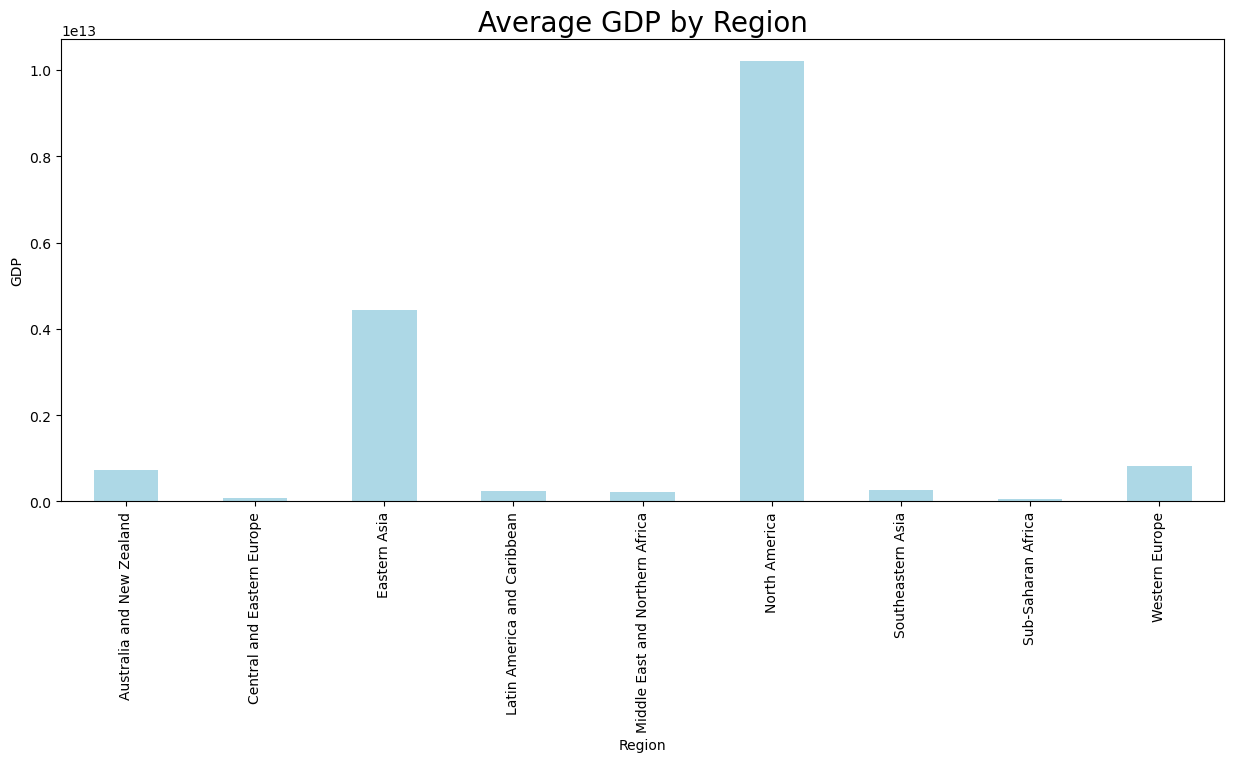

In [340]:
#Average GDP by Region
#***** need to adjust GDP per capita to just GDP (mult by pop of each country) before taking average
plt.figure(figsize=(15, 6))
gdp_df.groupby('Region')['GDP'].mean().plot(kind='bar', color='lightblue')
plt.title('Average GDP by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('GDP')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'GDP')

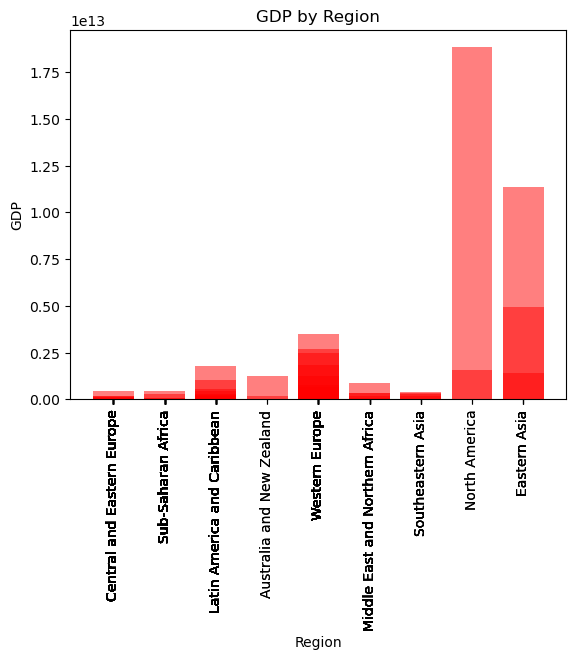

In [341]:
#chart for GDP by Region
gdp=gdp_df["GDP"]
region=gdp_df["Region"]

plt.bar(region,gdp,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("GDP by Region")
plt.xlabel("Region")
plt.ylabel("GDP")


In [342]:
#top 20 GDP countries
gdp=gdp_df.sort_values(["GDP"],ascending=False)
gdp.head(25)

,Country,Region,GDP
104,United States,North America,1.882229e+13
22,China,Eastern Asia,1.138620e+13
51,Japan,Eastern Asia,4.942078e+12
39,Germany,Western Europe,3.501360e+12
103,United Kingdom,Western Europe,2.685795e+12
36,France,Western Europe,2.476128e+12
49,Italy,Western Europe,1.853075e+12
14,Brazil,Latin America and Caribbean,1.815629e+12
19,Canada,North America,1.569669e+12
91,South Korea,Eastern Asia,1.398213e+12


<Figure size 1500x1000 with 0 Axes>

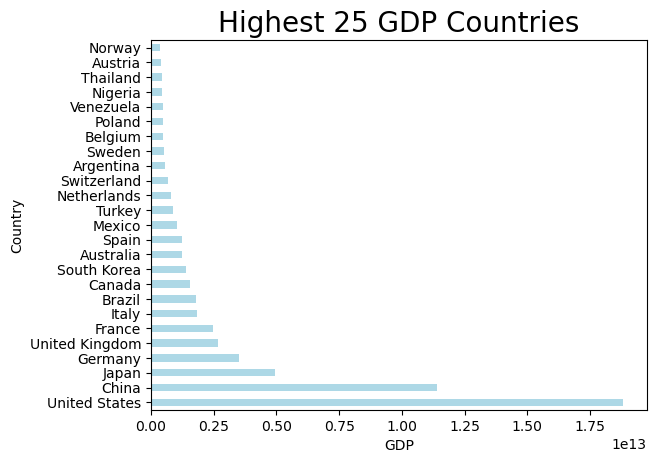

In [345]:
#chart top 25 countries by GDP
gdp=gdp_df["GDP"]
country=gdp_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = gdp_df.nlargest(25, 'GDP')
top_25_countries.plot(kind='barh', x='Country', y='GDP', color='lightblue', legend=False)
plt.title('Highest 25 GDP Countries', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.show()


In [344]:
#bottom 20 GDP countries
gdp=gdp_df.sort_values(["GDP"],ascending=True)
gdp.head(25)

,Country,Region,GDP
24,Comoros,Sub-Saharan Africa,6.016426e+08
10,Belize,Latin America and Caribbean,1.895047e+09
57,Liberia,Sub-Saharan Africa,2.224673e+09
93,Suriname,Latin America and Caribbean,3.485701e+09
87,Sierra Leone,Sub-Saharan Africa,3.781276e+09
68,Montenegro,Central and Eastern Europe,4.373634e+09
98,Togo,Sub-Saharan Africa,4.642934e+09
66,Moldova,Central and Eastern Europe,5.178879e+09
61,Malawi,Sub-Saharan Africa,5.510365e+09
43,Haiti,Latin America and Caribbean,8.094129e+09


<Figure size 1500x1000 with 0 Axes>

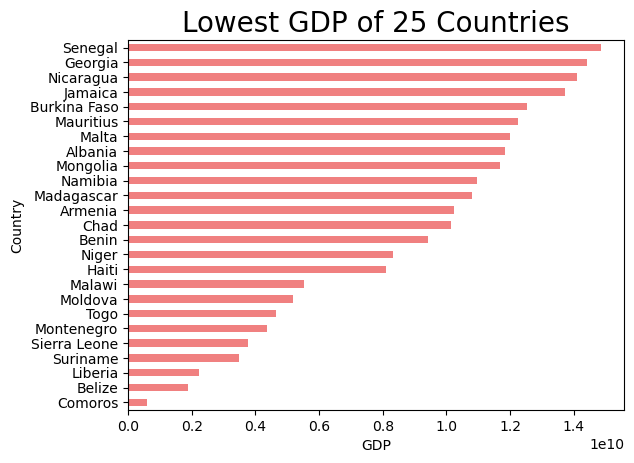

In [347]:
#Bottom 25 countries by GDP
plt.figure(figsize=(15, 10))
smallest_25_countries = gdp_df.nsmallest(25, 'GDP')
smallest_25_countries.plot(kind='barh', x='Country', y='GDP', color='lightcoral', legend=False)
plt.title('Lowest GDP of 25 Countries', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.show()

# Human Deveolpment Index (HDI)
first by regional averages, then by country

In [348]:
#Analysing for HDI by Region
hdi_df=data_df[["Country","Region","HDI"]].copy()
hdi_df

,Country,Region,HDI
0,Denmark,Western Europe,928
1,Switzerland,Western Europe,943
2,Iceland,Western Europe,933
3,Norway,Western Europe,951
4,Finland,Western Europe,918
...,...,...,...
117,Tanzania,Sub-Saharan Africa,533
118,Liberia,Sub-Saharan Africa,432
119,Benin,Sub-Saharan Africa,512
120,Togo,Sub-Saharan Africa,500


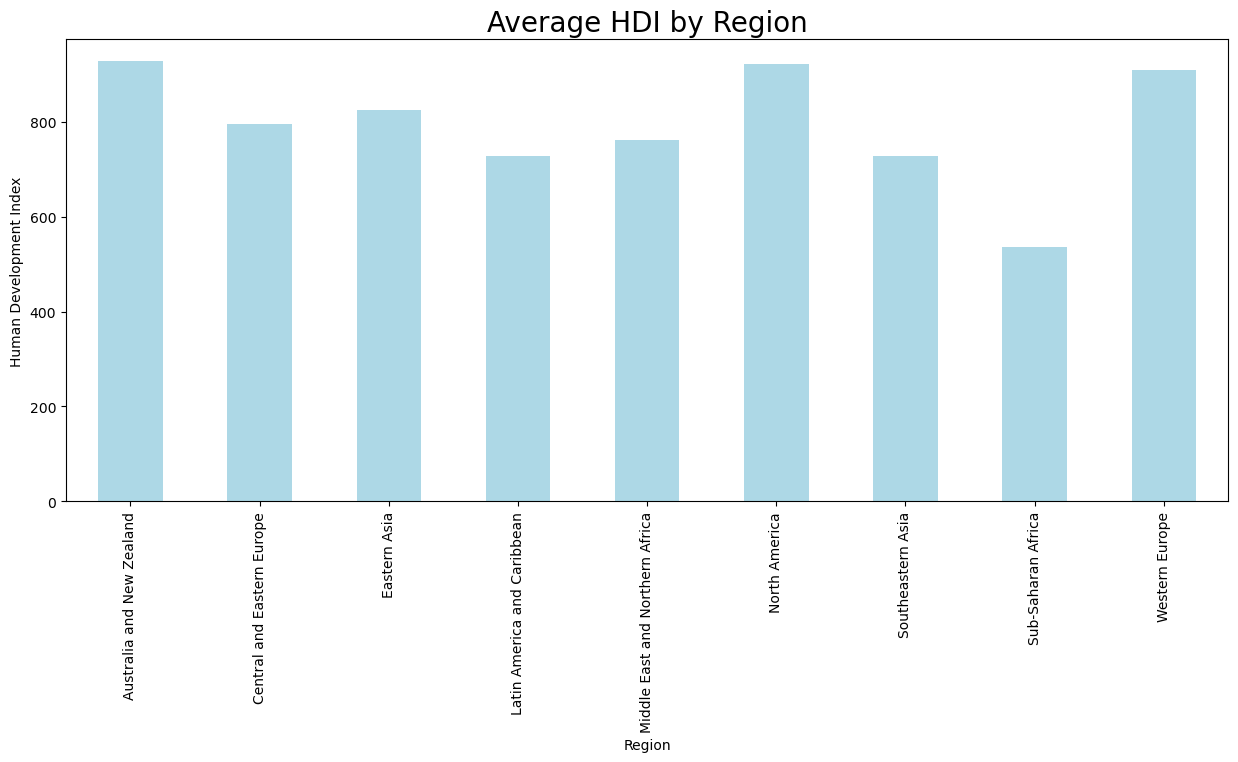

In [349]:
#average HDI per region
plt.figure(figsize=(15, 6))
hdi_df.groupby('Region')['HDI'].mean().plot(kind='bar', color='lightblue')
plt.title('Average HDI by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('Human Development Index')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'Human Development Index')

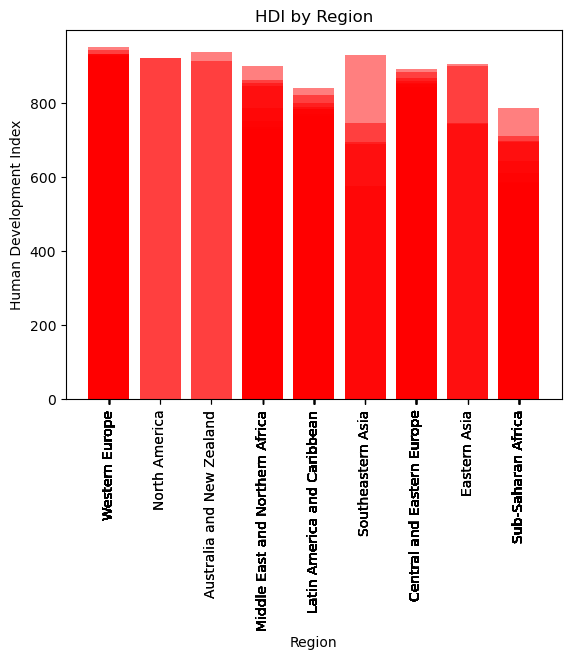

In [356]:
#HDI per region
hdi=hdi_df["HDI"]
region=hdi_df["Region"]

plt.bar(region,hdi,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("HDI by Region")
plt.xlabel("Region")
plt.ylabel("Human Development Index")

In [351]:
#Top 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=False)
hdi.head(25)

,Country,Region,HDI
3,Norway,Western Europe,951
1,Switzerland,Western Europe,943
8,Australia,Australia and New Zealand,938
14,Germany,Western Europe,934
17,Ireland,Western Europe,934
2,Iceland,Western Europe,933
9,Sweden,Western Europe,932
20,Singapore,Southeastern Asia,930
0,Denmark,Western Europe,928
6,Netherlands,Western Europe,928


<Figure size 1500x1000 with 0 Axes>

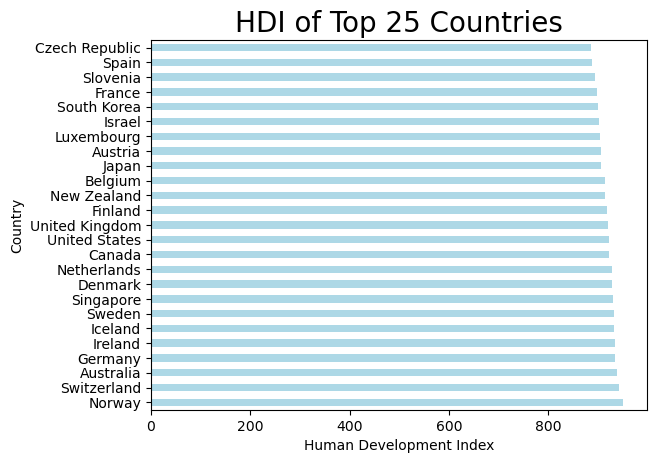

In [352]:
#Top 25 HDI Countries Graph
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nlargest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Top 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


In [353]:
#bottom 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=True)
hdi.head(25)

,Country,Region,HDI
113,Niger,Sub-Saharan Africa,351
114,Chad,Sub-Saharan Africa,405
89,Sierra Leone,Sub-Saharan Africa,413
115,Burkina Faso,Sub-Saharan Africa,420
106,Mali,Sub-Saharan Africa,421
118,Liberia,Sub-Saharan Africa,432
98,Dem. Rep. Congo,Sub-Saharan Africa,452
104,Malawi,Sub-Saharan Africa,474
110,Cote d'Ivoire,Sub-Saharan Africa,486
107,Haiti,Latin America and Caribbean,496


<Figure size 1500x1000 with 0 Axes>

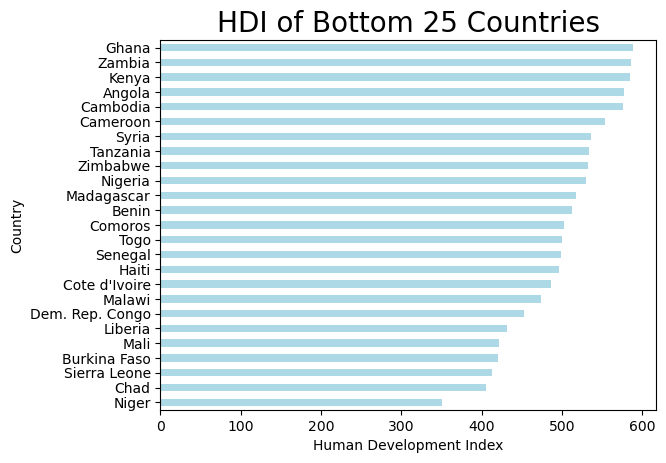

In [354]:
#bottom 25 HDI Countries
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nsmallest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Bottom 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


## Next Section